## Grad-CAM (Gradient-weighted Class Activation Mapping) 

Grad-Cam generates a heatmap by:
* Performing a forward pass to get the feature maps from the last convolutional layer.
* Doing a backward pass to calculate gradients of the target class with respect to these feature maps.
* Averaging the gradients across the width and height dimensions to get weights for each feature map.
* Combining the weighted feature maps to create a coarse heatmap that highlights the areas in the image most important for the target class.

## Steps
* Load the Model with Saved Weights
* Define the Grad-CAM Visualization Method
* Apply Grad-CAM to Test Images

In [2]:
import os
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define path to the saved model weights
model_path = '/kaggle/input/densenet121_dfuc_classification/pytorch/default/1/densenet121_best_model.pth'  # Update with your actual model path

# Load the DenseNet121 model architecture
model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 4)  # Adjust the number of classes as needed

# Try loading the model state_dict with weights_only=True if available, and strict=False for flexibility
try:
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True), strict=False)
    print("Model loaded using state_dict with weights_only=True.")
except TypeError:
    # Fallback if weights_only=True is not supported in this PyTorch version
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    print("Model loaded using state_dict without weights_only.")

# Set the model to evaluation mode and move it to the specified device
model.eval()
model.to(device)

# Define the Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def forward_hook(module, input, output):
            self.activations = output

        # Register hooks for forward and backward passes
        self.target_layer.register_backward_hook(backward_hook)
        self.target_layer.register_forward_hook(forward_hook)

    def __call__(self, x, class_idx=None):
        x = x.to(device)
        self.model.zero_grad()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Compute gradients for the target class
        one_hot = torch.zeros((1, output.size()[-1]), device=x.device)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot)

        # Compute Grad-CAM
        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU to remove negative values
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# Initialize Grad-CAM with the last convolutional layer of DenseNet121
gradcam = GradCAM(model=model, target_layer=model.features.denseblock4.denselayer16.conv2)

# Preprocessing transformation for the input images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Function to display the Grad-CAM heatmap on an image
def show_gradcam(img_path, gradcam, categories):
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0)
    cam = gradcam(input_tensor)

    # Convert image to numpy for visualization
    img = np.array(img)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img

    # Display the original image and Grad-CAM heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img / 255)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded using state_dict with weights_only=True.


Category: infection


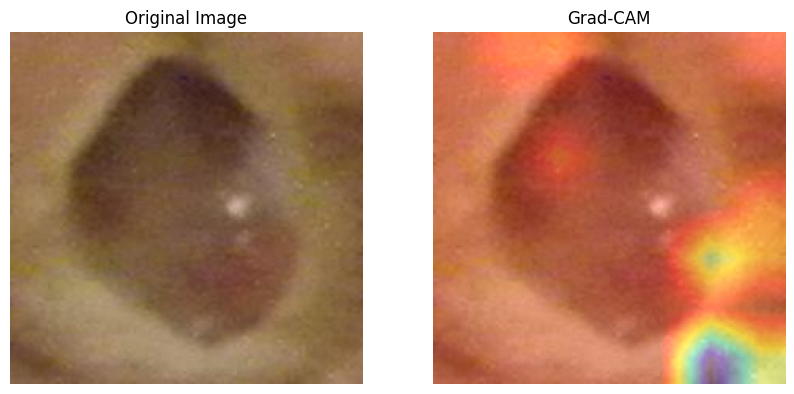

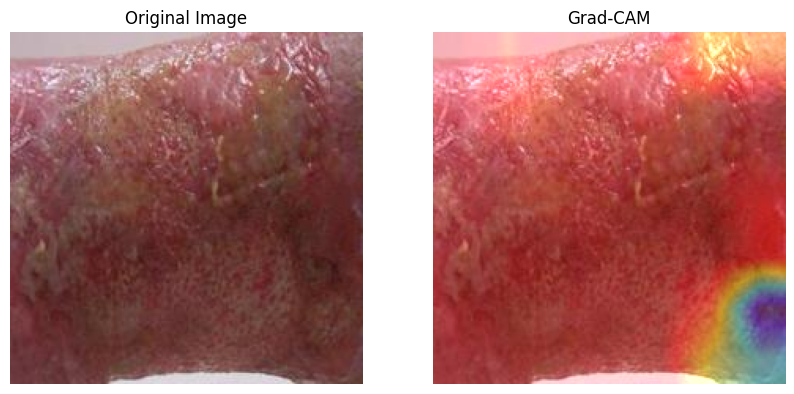

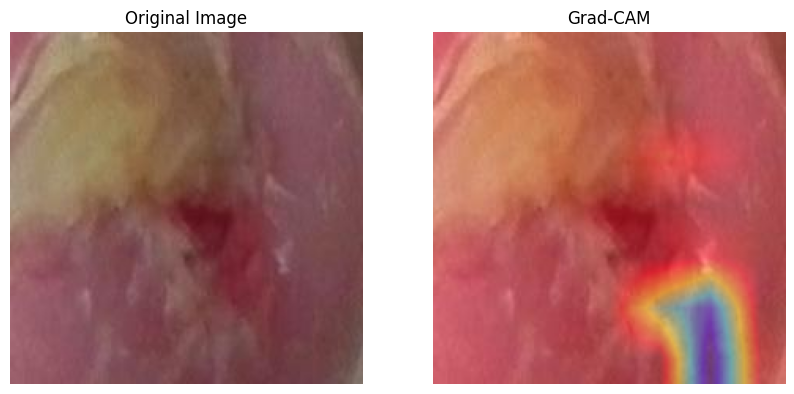

Category: both


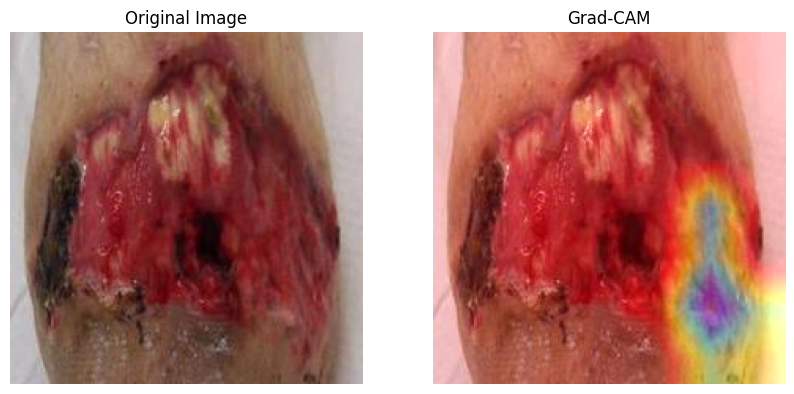

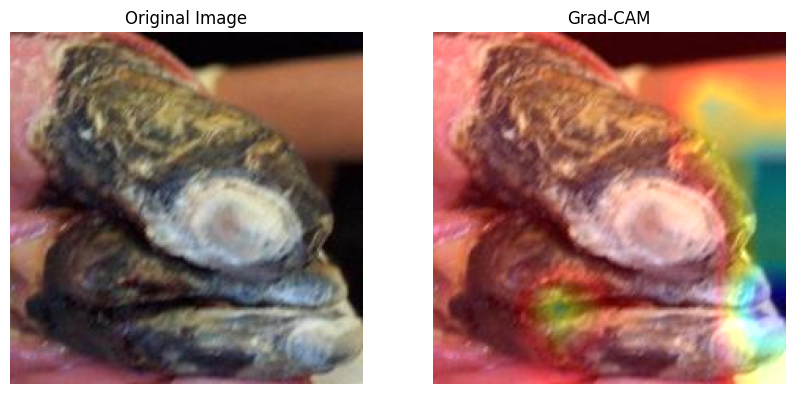

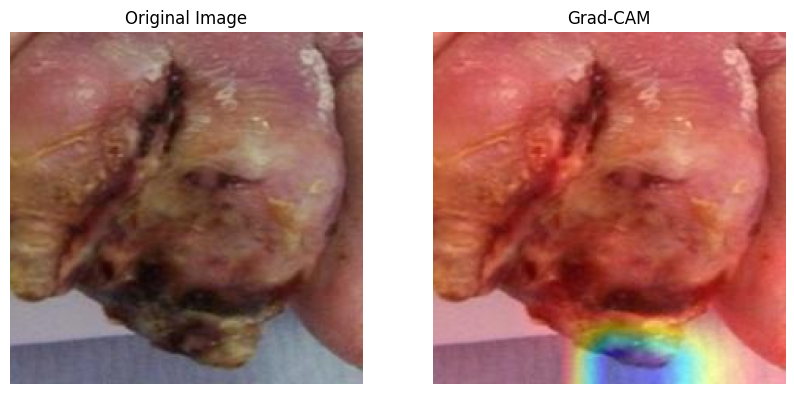

Category: ischaemia


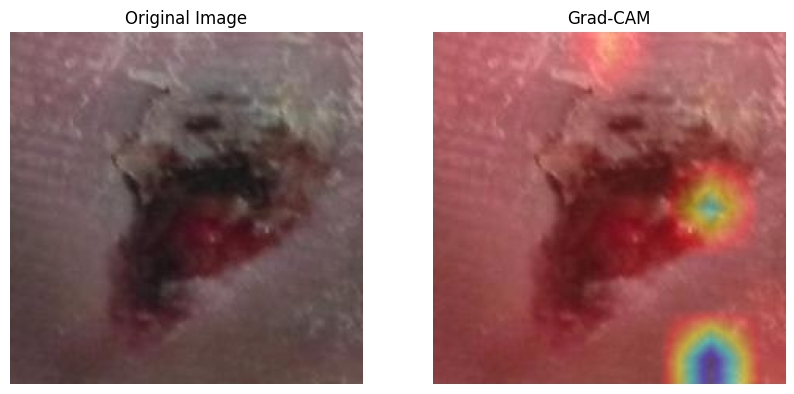

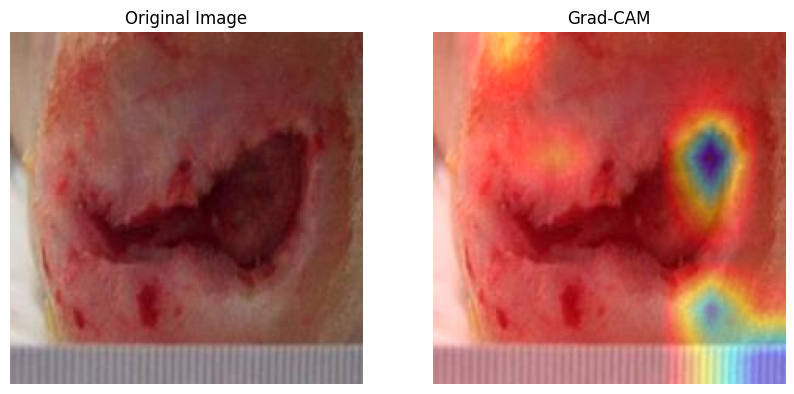

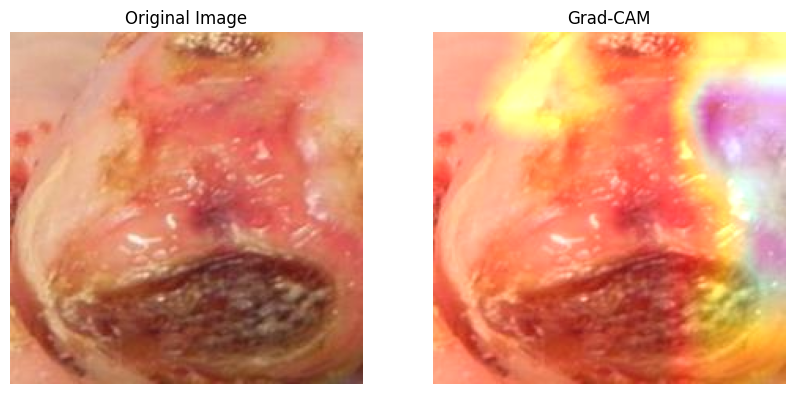

Category: none


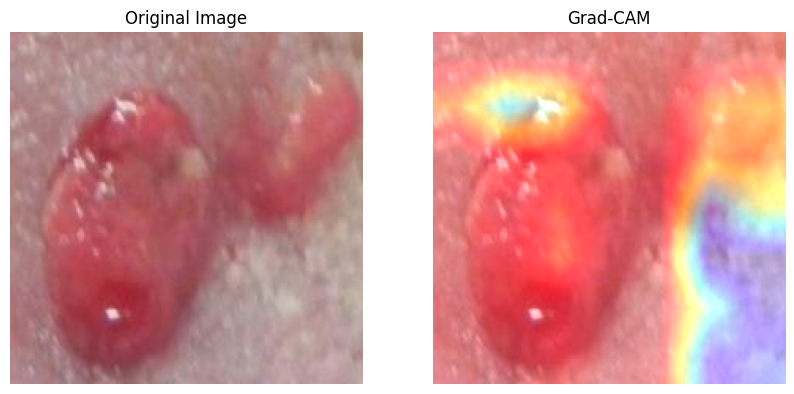

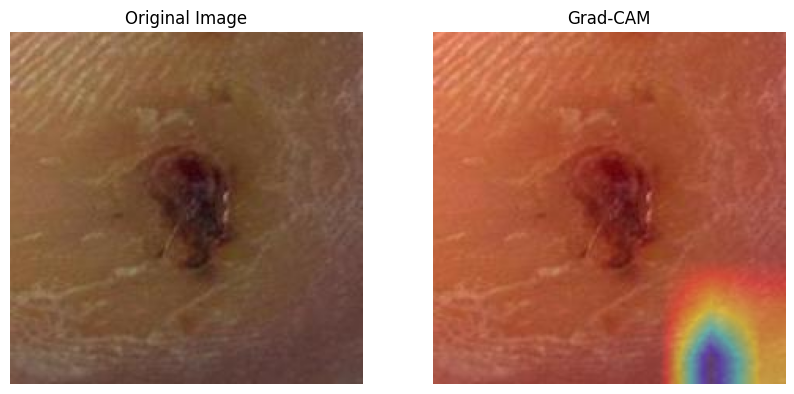

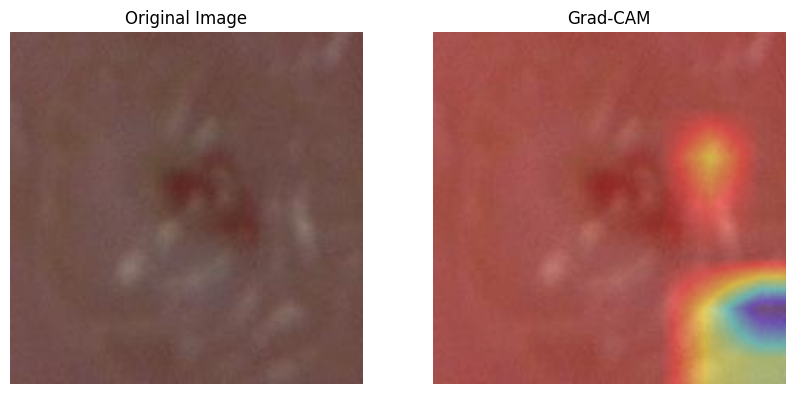

In [5]:
# Define path to the test dataset
test_dir = '/kaggle/input/dfuc-2021-split/A NEW DATASET SPLIT/test'  # Update this path as needed

# Dynamically read categories from subfolders in the test directory
categories = [folder for folder in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, folder))]

# Function to apply Grad-CAM on multiple images from the test dataset
def visualize_gradcam_for_testset(gradcam, test_dir, categories, num_images=3):
    for category in categories:
        category_path = os.path.join(test_dir, category)
        images = [os.path.join(category_path, img) for img in os.listdir(category_path)]
        
        # Randomly select images from each category
        selected_images = random.sample(images, min(num_images, len(images)))
        
        print(f"Category: {category}")
        for img_path in selected_images:
            show_gradcam(img_path, gradcam, categories)

# Run Grad-CAM visualization on images from each category
visualize_gradcam_for_testset(gradcam, test_dir, categories, num_images=3)
